# Manua Loa CO_2 dataset with Recurrent NN Model


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [9]:
# file path
file_path = "./data/CO2_MaunaLoa2025.csv"
# Load dataset
df = pd.read_csv(file_path)
print(df.head())

   month  decimal date  average  deseasonalized  ndays  sdev   unc
0      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4      7     1958.5370   315.87          315.20     -1 -9.99 -0.99


#### Detrend time series


In [ ]:
co2_values = df['average'].values # get the co2 values

# detrend the time series
diff_co2 = co2_values[1:] - co2_values[:-1]

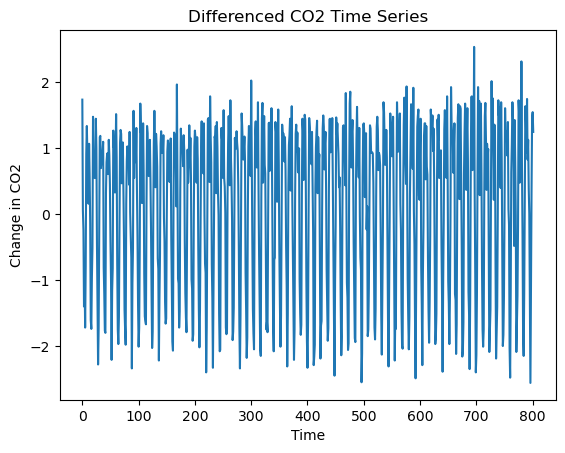

In [15]:
plt.plot(diff_co2)
plt.title('Differenced CO2 Time Series')
plt.xlabel('Time')
plt.ylabel('Change in CO2')
plt.show()

In [20]:
# Prepare supervised learning dataset
def gen_data_splits(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [21]:

window_size = 12
X, y = gen_data_splits(diff_co2, window_size)

# Split into train and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
X_train[0]

array([ 1.74,  0.06, -0.24, -1.4 , -0.94, -1.72, -0.79,  0.91,  1.34,
        0.91,  0.91,  0.16])

### Baseline Models


In [23]:
# Persistence Model
y_pred_persistence = X_test[:, -1]
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
print(f'Persistence Model MSE: {mse_persistence:.4f}')

Persistence Model MSE: 1.1581


In [24]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr:.4f}')

Linear Regression MSE: 0.2115


In [59]:
# MLP Model
inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(inp)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inp, out)
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])

y_pred_mlp = model.predict(X_test, verbose=0)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f'MLP Model MSE: {mse_mlp:.4f}')

MLP Model MSE: 0.1702


### Recurrent Neural Networks

In [61]:
# Step (c): Recurrent Neural Networks (RNN, LSTM, GRU)
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def build_rnn_model(cell_type='SimpleRNN', units=50):
    model = tf.keras.models.Sequential()
    if cell_type == 'SimpleRNN':
        model.add(tf.keras.layers.SimpleRNN(units, input_shape=(window_size, 1)))
    elif cell_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(units, input_shape=(window_size, 1)))
    elif cell_type == 'GRU':
        model.add(tf.keras.layers.GRU(units, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
    return model

for cell in ['SimpleRNN', 'LSTM', 'GRU']:
    model = build_rnn_model(cell)
    model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred_rnn = model.predict(X_test_rnn)
    mse_rnn = mean_squared_error(y_test, y_pred_rnn)
    print(f'{cell} Model MSE: {mse_rnn:.4f}')

/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
SimpleRNN Model MSE: 0.1847


/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model MSE: 0.1797


/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
GRU Model MSE: 0.1859
